##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2021-08-03 01:29:35.290679: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 2s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 1s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

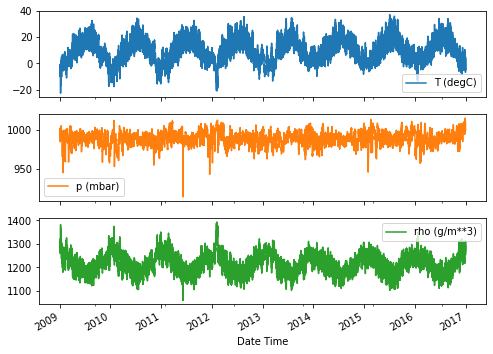

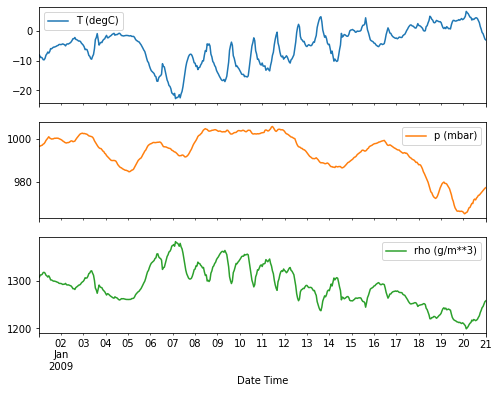

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

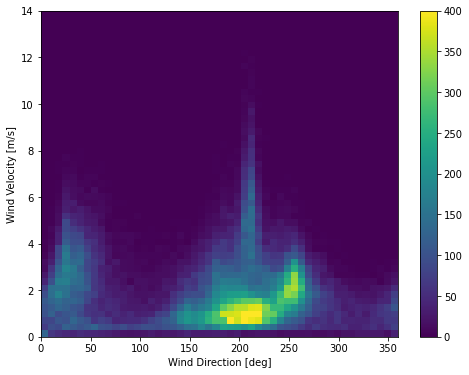

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

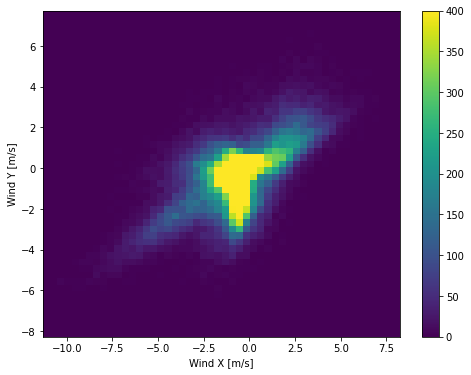

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

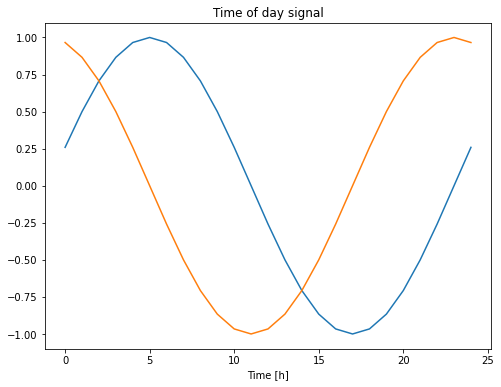

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


2021-08-03 01:29:41.976610: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-03 01:29:42.626738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-03 01:29:42.627640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-03 01:29:42.627697: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-03 01:29:42.630402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-03 01:29:42.630533: I tensorflow/stream_executor/platfo

2021-08-03 01:29:43.470908: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10


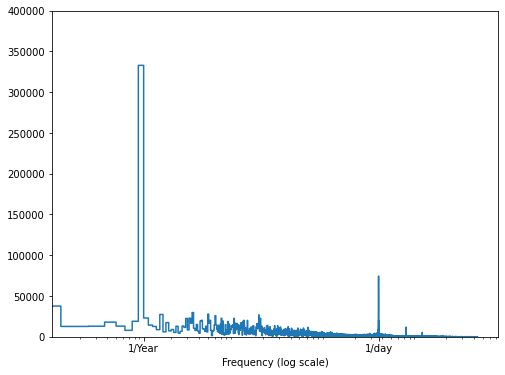

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

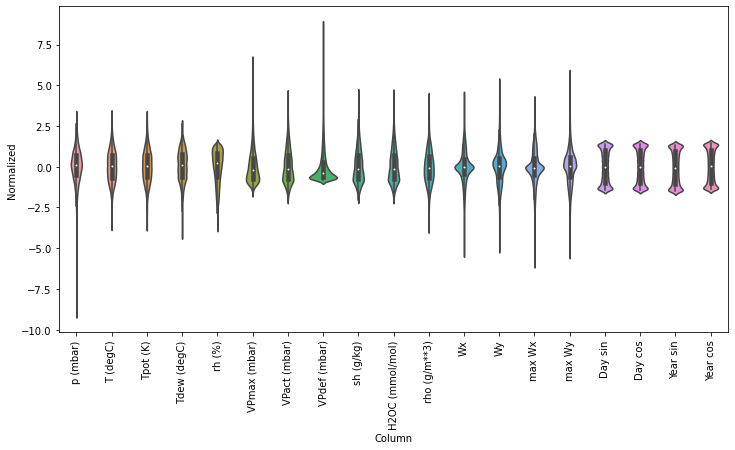

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](images/raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

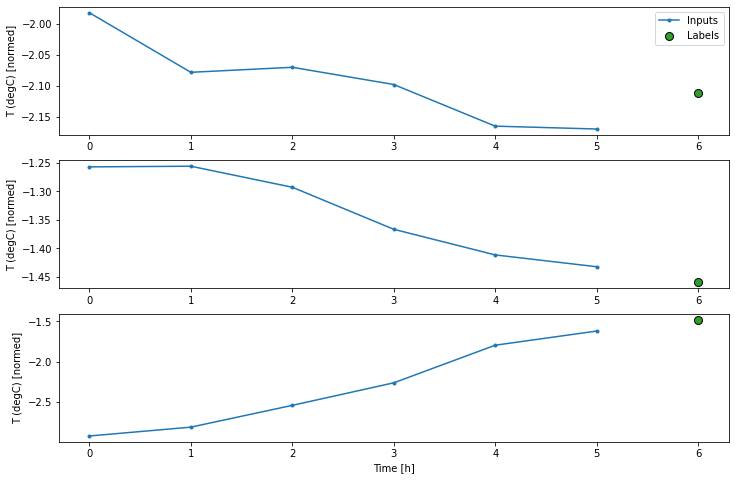

In [26]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

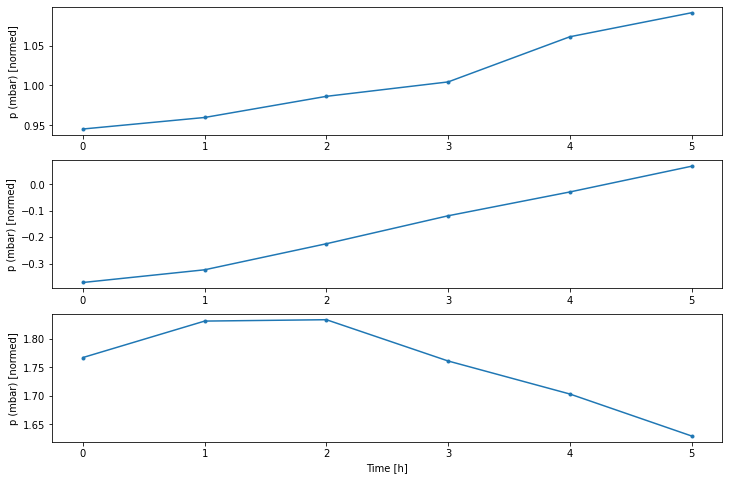

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function:

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


2021-08-03 01:29:50.245637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-03 01:29:50.246163: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000179999 Hz


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:13 - loss: 0.0158 - mean_absolute_error: 0.0944

 36/439 [=>............................] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0773  

 70/439 [===>..........................] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0786

105/439 [======>.......................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0794

140/439 [========>.....................] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0798

176/439 [===========>..................] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0797

213/439 [=============>................] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.0790

249/439 [================>.............] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0787

284/439 [==================>...........] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0788

319/439 [====================>.........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

355/439 [=======================>......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

390/439 [=========================>....] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

428/439 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

439/439 [==============================] - 1s 1ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

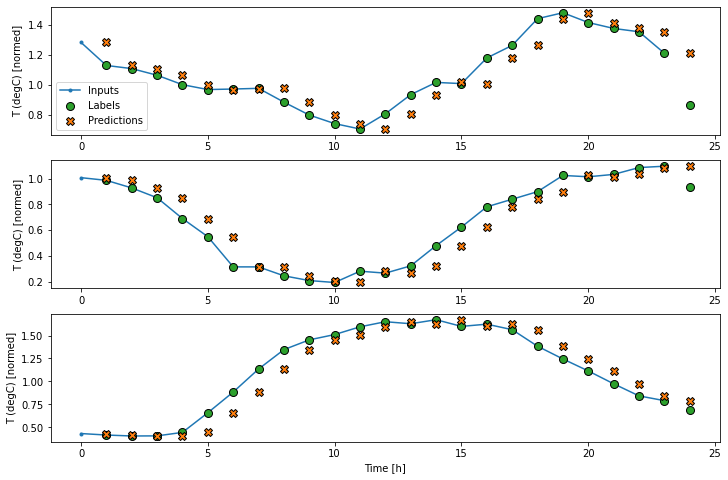

In [38]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


2021-08-03 01:29:52.088029: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


Output shape: (32, 1, 1)


2021-08-03 01:29:52.467708: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


This tutorial trains many models, so package the training procedure into a function:

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 7:25 - loss: 3.9046 - mean_absolute_error: 1.6648

  24/1534 [..............................] - ETA: 3s - loss: 3.6030 - mean_absolute_error: 1.5504  

  50/1534 [..............................] - ETA: 3s - loss: 3.2262 - mean_absolute_error: 1.4670

  72/1534 [>.............................] - ETA: 3s - loss: 2.9751 - mean_absolute_error: 1.4025

  97/1534 [>.............................] - ETA: 3s - loss: 2.6839 - mean_absolute_error: 1.3251

 121/1534 [=>............................] - ETA: 3s - loss: 2.4793 - mean_absolute_error: 1.2671

 146/1534 [=>............................] - ETA: 2s - loss: 2.2742 - mean_absolute_error: 1.2088

 171/1534 [==>...........................] - ETA: 2s - loss: 2.1236 - mean_absolute_error: 1.1645

 197/1534 [==>...........................] - ETA: 2s - loss: 1.9725 - mean_absolute_error: 1.1174

 219/1534 [===>..........................] - ETA: 2s - loss: 1.8610 - mean_absolute_error: 1.0811

 242/1534 [===>..........................] - ETA: 2s - loss: 1.7528 - mean_absolute_error: 1.0443

 266/1534 [====>.........................] - ETA: 2s - loss: 1.6514 - mean_absolute_error: 1.0084

 290/1534 [====>.........................] - ETA: 2s - loss: 1.5562 - mean_absolute_error: 0.9728

 313/1534 [=====>........................] - ETA: 2s - loss: 1.4764 - mean_absolute_error: 0.9424

 337/1534 [=====>........................] - ETA: 2s - loss: 1.3996 - mean_absolute_error: 0.9126

 360/1534 [======>.......................] - ETA: 2s - loss: 1.3311 - mean_absolute_error: 0.8836

 385/1534 [======>.......................] - ETA: 2s - loss: 1.2655 - mean_absolute_error: 0.8563

 409/1534 [======>.......................] - ETA: 2s - loss: 1.2062 - mean_absolute_error: 0.8305

 434/1534 [=======>......................] - ETA: 2s - loss: 1.1494 - mean_absolute_error: 0.8047

 457/1534 [=======>......................] - ETA: 2s - loss: 1.1020 - mean_absolute_error: 0.7830

 480/1534 [========>.....................] - ETA: 2s - loss: 1.0587 - mean_absolute_error: 0.7629

 504/1534 [========>.....................] - ETA: 2s - loss: 1.0169 - mean_absolute_error: 0.7433

 528/1534 [=========>....................] - ETA: 2s - loss: 0.9783 - mean_absolute_error: 0.7250

 552/1534 [=========>....................] - ETA: 2s - loss: 0.9425 - mean_absolute_error: 0.7072

 577/1534 [==========>...................] - ETA: 2s - loss: 0.9075 - mean_absolute_error: 0.6896

 601/1534 [==========>...................] - ETA: 1s - loss: 0.8767 - mean_absolute_error: 0.6738

 625/1534 [===========>..................] - ETA: 1s - loss: 0.8475 - mean_absolute_error: 0.6586

 649/1534 [===========>..................] - ETA: 1s - loss: 0.8205 - mean_absolute_error: 0.6442

 673/1534 [============>.................] - ETA: 1s - loss: 0.7951 - mean_absolute_error: 0.6306

 698/1534 [============>.................] - ETA: 1s - loss: 0.7702 - mean_absolute_error: 0.6172

 721/1534 [=============>................] - ETA: 1s - loss: 0.7485 - mean_absolute_error: 0.6052

 746/1534 [=============>................] - ETA: 1s - loss: 0.7267 - mean_absolute_error: 0.5933

 770/1534 [==============>...............] - ETA: 1s - loss: 0.7066 - mean_absolute_error: 0.5820

 795/1534 [==============>...............] - ETA: 1s - loss: 0.6870 - mean_absolute_error: 0.5709

 820/1534 [===============>..............] - ETA: 1s - loss: 0.6684 - mean_absolute_error: 0.5603

 845/1534 [===============>..............] - ETA: 1s - loss: 0.6508 - mean_absolute_error: 0.5501

 869/1534 [===============>..............] - ETA: 1s - loss: 0.6346 - mean_absolute_error: 0.5407

 894/1534 [================>.............] - ETA: 1s - loss: 0.6187 - mean_absolute_error: 0.5313

 918/1534 [================>.............] - ETA: 1s - loss: 0.6042 - mean_absolute_error: 0.5226

 942/1534 [=================>............] - ETA: 1s - loss: 0.5902 - mean_absolute_error: 0.5140

 966/1534 [=================>............] - ETA: 1s - loss: 0.5771 - mean_absolute_error: 0.5063

 990/1534 [==================>...........] - ETA: 1s - loss: 0.5644 - mean_absolute_error: 0.4986

1013/1534 [==================>...........] - ETA: 1s - loss: 0.5528 - mean_absolute_error: 0.4915

1037/1534 [===================>..........] - ETA: 1s - loss: 0.5413 - mean_absolute_error: 0.4844

1060/1534 [===================>..........] - ETA: 1s - loss: 0.5305 - mean_absolute_error: 0.4777

1085/1534 [====================>.........] - ETA: 0s - loss: 0.5194 - mean_absolute_error: 0.4707

1109/1534 [====================>.........] - ETA: 0s - loss: 0.5092 - mean_absolute_error: 0.4643

1133/1534 [=====================>........] - ETA: 0s - loss: 0.4993 - mean_absolute_error: 0.4579

1156/1534 [=====================>........] - ETA: 0s - loss: 0.4901 - mean_absolute_error: 0.4519

1180/1534 [======================>.......] - ETA: 0s - loss: 0.4810 - mean_absolute_error: 0.4461

1203/1534 [======================>.......] - ETA: 0s - loss: 0.4726 - mean_absolute_error: 0.4406

1228/1534 [=======================>......] - ETA: 0s - loss: 0.4637 - mean_absolute_error: 0.4348

1253/1534 [=======================>......] - ETA: 0s - loss: 0.4553 - mean_absolute_error: 0.4293

1278/1534 [=======================>......] - ETA: 0s - loss: 0.4471 - mean_absolute_error: 0.4239

1300/1534 [========================>.....] - ETA: 0s - loss: 0.4402 - mean_absolute_error: 0.4195

1322/1534 [========================>.....] - ETA: 0s - loss: 0.4335 - mean_absolute_error: 0.4151

1344/1534 [=========================>....] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.4107

1369/1534 [=========================>....] - ETA: 0s - loss: 0.4198 - mean_absolute_error: 0.4059

1393/1534 [==========================>...] - ETA: 0s - loss: 0.4131 - mean_absolute_error: 0.4013

1418/1534 [==========================>...] - ETA: 0s - loss: 0.4064 - mean_absolute_error: 0.3967

1442/1534 [===========================>..] - ETA: 0s - loss: 0.4001 - mean_absolute_error: 0.3924

1467/1534 [===========================>..] - ETA: 0s - loss: 0.3938 - mean_absolute_error: 0.3880

1491/1534 [============================>.] - ETA: 0s - loss: 0.3879 - mean_absolute_error: 0.3840

1517/1534 [============================>.] - ETA: 0s - loss: 0.3817 - mean_absolute_error: 0.3796

1534/1534 [==============================] - 4s 3ms/step - loss: 0.3780 - mean_absolute_error: 0.3770 - val_loss: 0.0286 - val_mean_absolute_error: 0.1310


Epoch 2/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0188 - mean_absolute_error: 0.1063

  24/1534 [..............................] - ETA: 3s - loss: 0.0268 - mean_absolute_error: 0.1309 

  48/1534 [..............................] - ETA: 3s - loss: 0.0257 - mean_absolute_error: 0.1273

  73/1534 [>.............................] - ETA: 3s - loss: 0.0248 - mean_absolute_error: 0.1254

  97/1534 [>.............................] - ETA: 3s - loss: 0.0250 - mean_absolute_error: 0.1256

 121/1534 [=>............................] - ETA: 2s - loss: 0.0250 - mean_absolute_error: 0.1252

 145/1534 [=>............................] - ETA: 2s - loss: 0.0242 - mean_absolute_error: 0.1228

 170/1534 [==>...........................] - ETA: 2s - loss: 0.0241 - mean_absolute_error: 0.1221

 194/1534 [==>...........................] - ETA: 2s - loss: 0.0237 - mean_absolute_error: 0.1212

 220/1534 [===>..........................] - ETA: 2s - loss: 0.0234 - mean_absolute_error: 0.1203

 243/1534 [===>..........................] - ETA: 2s - loss: 0.0230 - mean_absolute_error: 0.1192

 268/1534 [====>.........................] - ETA: 2s - loss: 0.0229 - mean_absolute_error: 0.1187

 292/1534 [====>.........................] - ETA: 2s - loss: 0.0226 - mean_absolute_error: 0.1180

 316/1534 [=====>........................] - ETA: 2s - loss: 0.0224 - mean_absolute_error: 0.1172

 340/1534 [=====>........................] - ETA: 2s - loss: 0.0221 - mean_absolute_error: 0.1163

 365/1534 [======>.......................] - ETA: 2s - loss: 0.0219 - mean_absolute_error: 0.1156

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0216 - mean_absolute_error: 0.1149

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0213 - mean_absolute_error: 0.1140

 438/1534 [=======>......................] - ETA: 2s - loss: 0.0210 - mean_absolute_error: 0.1131

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0208 - mean_absolute_error: 0.1126

 487/1534 [========>.....................] - ETA: 2s - loss: 0.0206 - mean_absolute_error: 0.1119

 512/1534 [=========>....................] - ETA: 2s - loss: 0.0204 - mean_absolute_error: 0.1114

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0203 - mean_absolute_error: 0.1109

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0201 - mean_absolute_error: 0.1102

 585/1534 [==========>...................] - ETA: 1s - loss: 0.0199 - mean_absolute_error: 0.1097

 610/1534 [==========>...................] - ETA: 1s - loss: 0.0198 - mean_absolute_error: 0.1093

 635/1534 [===========>..................] - ETA: 1s - loss: 0.0197 - mean_absolute_error: 0.1089

 659/1534 [===========>..................] - ETA: 1s - loss: 0.0196 - mean_absolute_error: 0.1084

 683/1534 [============>.................] - ETA: 1s - loss: 0.0195 - mean_absolute_error: 0.1079

 707/1534 [============>.................] - ETA: 1s - loss: 0.0193 - mean_absolute_error: 0.1073

 731/1534 [=============>................] - ETA: 1s - loss: 0.0191 - mean_absolute_error: 0.1067

 754/1534 [=============>................] - ETA: 1s - loss: 0.0189 - mean_absolute_error: 0.1062

 779/1534 [==============>...............] - ETA: 1s - loss: 0.0188 - mean_absolute_error: 0.1058

 803/1534 [==============>...............] - ETA: 1s - loss: 0.0187 - mean_absolute_error: 0.1053

 828/1534 [===============>..............] - ETA: 1s - loss: 0.0185 - mean_absolute_error: 0.1048

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0184 - mean_absolute_error: 0.1043

 876/1534 [================>.............] - ETA: 1s - loss: 0.0183 - mean_absolute_error: 0.1038

 901/1534 [================>.............] - ETA: 1s - loss: 0.0181 - mean_absolute_error: 0.1034

 927/1534 [=================>............] - ETA: 1s - loss: 0.0180 - mean_absolute_error: 0.1029

 950/1534 [=================>............] - ETA: 1s - loss: 0.0179 - mean_absolute_error: 0.1025

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0177 - mean_absolute_error: 0.1020

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0177 - mean_absolute_error: 0.1018

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0176 - mean_absolute_error: 0.1015

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0174 - mean_absolute_error: 0.1010

1070/1534 [===================>..........] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.1006

1093/1534 [====================>.........] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.1001

1118/1534 [====================>.........] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.0998

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.0994

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.0989

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0986

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0982

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0979

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0975

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0973

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0970

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.0967

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0965

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0962

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0160 - mean_absolute_error: 0.0959

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0956

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0953

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0950

1503/1534 [============================>.] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0948

1526/1534 [============================>.] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0946

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0156 - mean_absolute_error: 0.0945 - val_loss: 0.0105 - val_mean_absolute_error: 0.0761


Epoch 3/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0124 - mean_absolute_error: 0.0865

  24/1534 [..............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0780 

  49/1534 [..............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0752

  73/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0751

  96/1534 [>.............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0755

 119/1534 [=>............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0756

 144/1534 [=>............................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0750

 168/1534 [==>...........................] - ETA: 2s - loss: 0.0101 - mean_absolute_error: 0.0754

 192/1534 [==>...........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0755

 216/1534 [===>..........................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0758

 240/1534 [===>..........................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0757

 265/1534 [====>.........................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0759

 289/1534 [====>.........................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0760

 313/1534 [=====>........................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0757

 337/1534 [=====>........................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0760

 361/1534 [======>.......................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0761

 385/1534 [======>.......................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0760

 408/1534 [======>.......................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0760

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0102 - mean_absolute_error: 0.0758

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0759

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0758

 505/1534 [========>.....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0758

 529/1534 [=========>....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0759

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0103 - mean_absolute_error: 0.0758

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0104 - mean_absolute_error: 0.0759

 601/1534 [==========>...................] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0759

 624/1534 [===========>..................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0760

 649/1534 [===========>..................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0761

 672/1534 [============>.................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0761

 696/1534 [============>.................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0760

 720/1534 [=============>................] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0760

 744/1534 [=============>................] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0759

 767/1534 [==============>...............] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0760

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0759

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0758

 839/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 863/1534 [===============>..............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 887/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 910/1534 [================>.............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 934/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 956/1534 [=================>............] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0757

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0755

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0758

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0105 - mean_absolute_error: 0.0757

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0104 - mean_absolute_error: 0.0756

1078/1534 [====================>.........] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0756

1101/1534 [====================>.........] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0756

1126/1534 [=====================>........] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0755

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.0754

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0753

1197/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0753

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0751

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0752

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0751

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0751

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.0750

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0750

1485/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0749

1510/1534 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0749

1534/1534 [==============================] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0750

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0102 - mean_absolute_error: 0.0750 - val_loss: 0.0093 - val_mean_absolute_error: 0.0718


Epoch 4/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0053 - mean_absolute_error: 0.0586

  25/1534 [..............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0722 

  49/1534 [..............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0688

  73/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0697

  98/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0696

 122/1534 [=>............................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0702

 146/1534 [=>............................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0703

 169/1534 [==>...........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0705

 195/1534 [==>...........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0711

 219/1534 [===>..........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0710

 245/1534 [===>..........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0709

 268/1534 [====>.........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0711

 293/1534 [====>.........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0714

 316/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0714

 342/1534 [=====>........................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0716

 366/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0715

 392/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0715

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0715

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0715

 465/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0716

 491/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0715

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0716

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0716

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0717

 589/1534 [==========>...................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0717

 612/1534 [==========>...................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 635/1534 [===========>..................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0720

 659/1534 [===========>..................] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

 684/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0721

 709/1534 [============>.................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0721

 734/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0720

 759/1534 [=============>................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0720

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0720

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0718

 886/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 911/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 936/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 960/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0719

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1057/1534 [===================>..........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1081/1534 [====================>.........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1104/1534 [====================>.........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1128/1534 [=====================>........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1178/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0718

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0718

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0718

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0718

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0718

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1485/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0716

1508/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1534/1534 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0717

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0717 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700


Epoch 5/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0096 - mean_absolute_error: 0.0690

  25/1534 [..............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0689 

  50/1534 [..............................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0674

  75/1534 [>.............................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0675

 100/1534 [>.............................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0676

 125/1534 [=>............................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0682

 150/1534 [=>............................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0684

 175/1534 [==>...........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0687

 200/1534 [==>...........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0688

 225/1534 [===>..........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0690

 250/1534 [===>..........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0691

 275/1534 [====>.........................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0692

 302/1534 [====>.........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0694

 328/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0699

 353/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0698

 379/1534 [======>.......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0697

 404/1534 [======>.......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0698

 430/1534 [=======>......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0698

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0698

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0698

 508/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0698

 534/1534 [=========>....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0700

 560/1534 [=========>....................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0700

 585/1534 [==========>...................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0700

 610/1534 [==========>...................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 635/1534 [===========>..................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

 661/1534 [===========>..................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0704

 686/1534 [============>.................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 712/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0704

 738/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0704

 764/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0704

 789/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0702

 891/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0703

 917/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 943/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 969/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1047/1534 [===================>..........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1073/1534 [===================>..........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1098/1534 [====================>.........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1199/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0703

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1503/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1531/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1534/1534 [==============================] - 4s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0088 - val_mean_absolute_error: 0.0697


Epoch 6/20
   1/1534 [..............................] - ETA: 25s - loss: 0.0067 - mean_absolute_error: 0.0620

  27/1534 [..............................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0700 

  53/1534 [>.............................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0679

  78/1534 [>.............................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0675

 104/1534 [=>............................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0679

 130/1534 [=>............................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0681

 156/1534 [==>...........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0678

 182/1534 [==>...........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0683

 207/1534 [===>..........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0685

 233/1534 [===>..........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0684

 258/1534 [====>.........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0687

 283/1534 [====>.........................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0690

 309/1534 [=====>........................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0691

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0693

 360/1534 [======>.......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0694

 386/1534 [======>.......................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0693

 412/1534 [=======>......................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0693

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0692

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0694

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0693

 515/1534 [=========>....................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0694

 540/1534 [=========>....................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0696

 566/1534 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0695

 592/1534 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0695

 618/1534 [===========>..................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0697

 643/1534 [===========>..................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 669/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 694/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 718/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0700

 741/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 764/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0699

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0698

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 888/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 939/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 963/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1039/1534 [===================>..........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1062/1534 [===================>..........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1087/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1112/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1138/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1499/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1524/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 4s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0694


Epoch 7/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0075 - mean_absolute_error: 0.0610

  27/1534 [..............................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0658 

  54/1534 [>.............................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0662

  81/1534 [>.............................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0664

 108/1534 [=>............................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0671

 135/1534 [=>............................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0674

 162/1534 [==>...........................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0669

 187/1534 [==>...........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0677

 214/1534 [===>..........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0676

 239/1534 [===>..........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0677

 264/1534 [====>.........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0679

 290/1534 [====>.........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0681

 317/1534 [=====>........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0685

 344/1534 [=====>........................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0687

 369/1534 [======>.......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0685

 396/1534 [======>.......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0686

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0686

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0687

 473/1534 [========>.....................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0686

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0687

 524/1534 [=========>....................] - ETA: 1s - loss: 0.0087 - mean_absolute_error: 0.0689

 550/1534 [=========>....................] - ETA: 1s - loss: 0.0087 - mean_absolute_error: 0.0688

 576/1534 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0689

 602/1534 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0690

 629/1534 [===========>..................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0692

 655/1534 [===========>..................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 681/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 708/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 733/1534 [=============>................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0694

 757/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 833/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 859/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 884/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 909/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 935/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 961/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1037/1534 [===================>..........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1062/1534 [===================>..........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1085/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1110/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1134/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1159/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0694

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1494/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1518/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 4s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0697


Epoch 8/20
   1/1534 [..............................] - ETA: 30s - loss: 0.0124 - mean_absolute_error: 0.0785

  24/1534 [..............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0685 

  49/1534 [..............................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0659

  73/1534 [>.............................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0647

  98/1534 [>.............................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0669

 123/1534 [=>............................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0674

 147/1534 [=>............................] - ETA: 2s - loss: 0.0082 - mean_absolute_error: 0.0672

 171/1534 [==>...........................] - ETA: 2s - loss: 0.0083 - mean_absolute_error: 0.0673

 195/1534 [==>...........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0677

 219/1534 [===>..........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0680

 242/1534 [===>..........................] - ETA: 2s - loss: 0.0084 - mean_absolute_error: 0.0680

 267/1534 [====>.........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0684

 291/1534 [====>.........................] - ETA: 2s - loss: 0.0085 - mean_absolute_error: 0.0683

 315/1534 [=====>........................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0685

 338/1534 [=====>........................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0688

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0687

 387/1534 [======>.......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0686

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0687

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0688

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0689

 484/1534 [========>.....................] - ETA: 2s - loss: 0.0086 - mean_absolute_error: 0.0687

 506/1534 [========>.....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0688

 529/1534 [=========>....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0689

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0689

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0087 - mean_absolute_error: 0.0689

 602/1534 [==========>...................] - ETA: 1s - loss: 0.0088 - mean_absolute_error: 0.0691

 624/1534 [===========>..................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0693

 649/1534 [===========>..................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0695

 672/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 697/1534 [============>.................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 720/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 746/1534 [=============>................] - ETA: 1s - loss: 0.0089 - mean_absolute_error: 0.0695

 770/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 843/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 890/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 914/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 938/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 962/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1086/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1112/1534 [====================>.........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1137/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1432/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1505/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1529/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.0698


  1/439 [..............................] - ETA: 20s - loss: 0.0110 - mean_absolute_error: 0.0704

 30/439 [=>............................] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0728 

 62/439 [===>..........................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0719

 91/439 [=====>........................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0715

121/439 [=======>......................] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0711

150/439 [=========>....................] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0702

180/439 [===========>..................] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

210/439 [=============>................] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0707

240/439 [===============>..............] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0708

269/439 [=================>............] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0705

299/439 [===================>..........] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0704

330/439 [=====================>........] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0702

360/439 [=======================>......] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0701

390/439 [=========================>....] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0700

418/439 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0700

439/439 [==============================] - 1s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0698


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

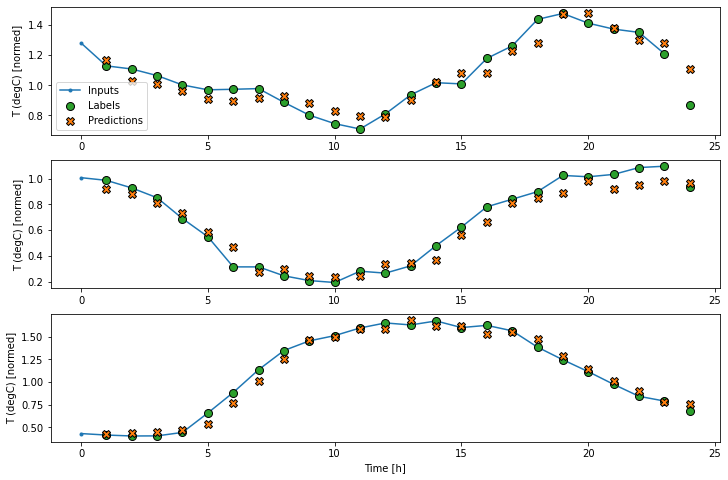

In [44]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

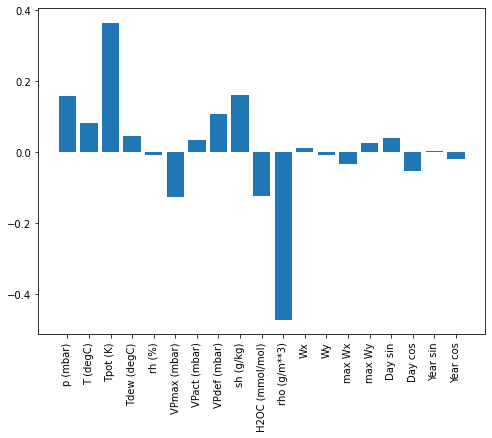

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 10:45 - loss: 0.8827 - mean_absolute_error: 0.7760

  19/1534 [..............................] - ETA: 4s - loss: 0.2591 - mean_absolute_error: 0.3777   

  37/1534 [..............................] - ETA: 4s - loss: 0.1595 - mean_absolute_error: 0.2825

  56/1534 [>.............................] - ETA: 4s - loss: 0.1173 - mean_absolute_error: 0.2358

  74/1534 [>.............................] - ETA: 4s - loss: 0.0945 - mean_absolute_error: 0.2073

  91/1534 [>.............................] - ETA: 4s - loss: 0.0811 - mean_absolute_error: 0.1899

 109/1534 [=>............................] - ETA: 4s - loss: 0.0706 - mean_absolute_error: 0.1757

 127/1534 [=>............................] - ETA: 3s - loss: 0.0630 - mean_absolute_error: 0.1649

 145/1534 [=>............................] - ETA: 3s - loss: 0.0569 - mean_absolute_error: 0.1552

 162/1534 [==>...........................] - ETA: 3s - loss: 0.0521 - mean_absolute_error: 0.1476

 181/1534 [==>...........................] - ETA: 3s - loss: 0.0482 - mean_absolute_error: 0.1417

 199/1534 [==>...........................] - ETA: 3s - loss: 0.0452 - mean_absolute_error: 0.1373

 218/1534 [===>..........................] - ETA: 3s - loss: 0.0422 - mean_absolute_error: 0.1323

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0400 - mean_absolute_error: 0.1289

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0381 - mean_absolute_error: 0.1256

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0364 - mean_absolute_error: 0.1229

 290/1534 [====>.........................] - ETA: 3s - loss: 0.0350 - mean_absolute_error: 0.1207

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0337 - mean_absolute_error: 0.1187

 326/1534 [=====>........................] - ETA: 3s - loss: 0.0324 - mean_absolute_error: 0.1167

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0314 - mean_absolute_error: 0.1148

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0303 - mean_absolute_error: 0.1129

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0294 - mean_absolute_error: 0.1112

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0284 - mean_absolute_error: 0.1094

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0276 - mean_absolute_error: 0.1077

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0268 - mean_absolute_error: 0.1064

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0261 - mean_absolute_error: 0.1051

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0256 - mean_absolute_error: 0.1041

 488/1534 [========>.....................] - ETA: 2s - loss: 0.0250 - mean_absolute_error: 0.1030

 506/1534 [========>.....................] - ETA: 2s - loss: 0.0245 - mean_absolute_error: 0.1020

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0240 - mean_absolute_error: 0.1011

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0236 - mean_absolute_error: 0.1004

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0232 - mean_absolute_error: 0.0996

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0227 - mean_absolute_error: 0.0986

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0222 - mean_absolute_error: 0.0977

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0219 - mean_absolute_error: 0.0971

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0216 - mean_absolute_error: 0.0964

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0212 - mean_absolute_error: 0.0957

 671/1534 [============>.................] - ETA: 2s - loss: 0.0209 - mean_absolute_error: 0.0950

 689/1534 [============>.................] - ETA: 2s - loss: 0.0206 - mean_absolute_error: 0.0945

 707/1534 [============>.................] - ETA: 2s - loss: 0.0203 - mean_absolute_error: 0.0940

 726/1534 [=============>................] - ETA: 2s - loss: 0.0201 - mean_absolute_error: 0.0935

 744/1534 [=============>................] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.0929

 762/1534 [=============>................] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.0923

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.0918

 800/1534 [==============>...............] - ETA: 2s - loss: 0.0191 - mean_absolute_error: 0.0913

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0188 - mean_absolute_error: 0.0908

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0186 - mean_absolute_error: 0.0903

 854/1534 [===============>..............] - ETA: 1s - loss: 0.0184 - mean_absolute_error: 0.0899

 872/1534 [================>.............] - ETA: 1s - loss: 0.0182 - mean_absolute_error: 0.0895

 891/1534 [================>.............] - ETA: 1s - loss: 0.0180 - mean_absolute_error: 0.0891

 908/1534 [================>.............] - ETA: 1s - loss: 0.0179 - mean_absolute_error: 0.0888

 927/1534 [=================>............] - ETA: 1s - loss: 0.0177 - mean_absolute_error: 0.0884

 945/1534 [=================>............] - ETA: 1s - loss: 0.0175 - mean_absolute_error: 0.0881

 964/1534 [=================>............] - ETA: 1s - loss: 0.0174 - mean_absolute_error: 0.0878

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0172 - mean_absolute_error: 0.0875

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0171 - mean_absolute_error: 0.0872

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0870

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0168 - mean_absolute_error: 0.0867

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0865

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0861

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0859

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0856

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0162 - mean_absolute_error: 0.0854

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0851

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0848

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0846

1199/1534 [======================>.......] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0845

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0843

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.0841

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.0839

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0837

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0835

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0833

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0830

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0827

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0826

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0824

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0822

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0821

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0818

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0817

1471/1534 [===========================>..] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0815

1490/1534 [============================>.] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0813

1509/1534 [============================>.] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0812

1527/1534 [============================>.] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0810

1534/1534 [==============================] - 6s 3ms/step - loss: 0.0143 - mean_absolute_error: 0.0809 - val_loss: 0.0078 - val_mean_absolute_error: 0.0638


Epoch 2/20
   1/1534 [..............................] - ETA: 33s - loss: 0.0092 - mean_absolute_error: 0.0692

  19/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0662 

  37/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0665

  55/1534 [>.............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0678

  73/1534 [>.............................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0684

  91/1534 [>.............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0686

 109/1534 [=>............................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0681

 128/1534 [=>............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0679

 146/1534 [=>............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0677

 166/1534 [==>...........................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0675

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0672

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0673

 221/1534 [===>..........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0671

 241/1534 [===>..........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0670

 259/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0668

 278/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0669

 297/1534 [====>.........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0667

 316/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0663

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0662

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0659

 408/1534 [======>.......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0657

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0655

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0654

 464/1534 [========>.....................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0655

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0655

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0078 - mean_absolute_error: 0.0653

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0654

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0655

 554/1534 [=========>....................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0655

 573/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0655

 591/1534 [==========>...................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0654

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 665/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 684/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 701/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 719/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0658

 737/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0658

 756/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 792/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0657

 810/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0656

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

 865/1534 [===============>..............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

 883/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

 902/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

 920/1534 [================>.............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

 939/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

 958/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0658

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0659

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0660

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0661

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0660

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0660

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0660

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0659

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0082 - mean_absolute_error: 0.0659

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0660

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0660

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0659

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0659

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0659

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.0659

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0658

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0658

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0657

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0657

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0657

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0656

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1495/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1514/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1532/1534 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0655

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0081 - mean_absolute_error: 0.0655 - val_loss: 0.0086 - val_mean_absolute_error: 0.0695


Epoch 3/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0080 - mean_absolute_error: 0.0693

  20/1534 [..............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0622 

  38/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

  56/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0646

  74/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0648

  93/1534 [>.............................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0653

 111/1534 [=>............................] - ETA: 3s - loss: 0.0078 - mean_absolute_error: 0.0641

 131/1534 [=>............................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0634

 149/1534 [=>............................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0634

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0630

 185/1534 [==>...........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 202/1534 [==>...........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 219/1534 [===>..........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0631

 238/1534 [===>..........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0627

 256/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0629

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0630

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0633

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0633

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0632

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0630

 420/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0630

 438/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0628

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0627

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0627

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0626

 510/1534 [========>.....................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0626

 528/1534 [=========>....................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 599/1534 [==========>...................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0629

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 669/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 688/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 706/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0628

 724/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 741/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 760/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0626

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0627

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0626

 832/1534 [===============>..............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 887/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 905/1534 [================>.............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 923/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 941/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

 959/1534 [=================>............] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0626

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0627

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0628

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0630

1137/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0629

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0630

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1227/1534 [======================>.......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0629

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1500/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1519/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0628

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0627 - val_loss: 0.0070 - val_mean_absolute_error: 0.0597


Epoch 4/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0035 - mean_absolute_error: 0.0417

  21/1534 [..............................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0626 

  41/1534 [..............................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

  60/1534 [>.............................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0621

  80/1534 [>.............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0613

 100/1534 [>.............................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0614

 119/1534 [=>............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0613

 138/1534 [=>............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0611

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0606

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0603

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0608

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0610

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0607

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0608

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0610

 290/1534 [====>.........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0610

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0608

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0610

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0611

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0609

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0607

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0605

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0603

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0602

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0604

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0604

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0604

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 556/1534 [=========>....................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 671/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 691/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 710/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 730/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0605

 750/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0606

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0607

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 846/1534 [===============>..............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 866/1534 [===============>..............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 885/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

 904/1534 [================>.............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

 923/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 942/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 961/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0607

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0608

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0609

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1497/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1516/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583


Epoch 5/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0059 - mean_absolute_error: 0.0587

  20/1534 [..............................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0593 

  39/1534 [..............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0590

  58/1534 [>.............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0590

  78/1534 [>.............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0599

  95/1534 [>.............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0599

 115/1534 [=>............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 135/1534 [=>............................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 212/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 231/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 269/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0594

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0595

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0592

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0591

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 498/1534 [========>.....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0592

 536/1534 [=========>....................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0594

 556/1534 [=========>....................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 575/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0595

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0594

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 672/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0595

 691/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0596

 710/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 729/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 749/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 807/1534 [==============>...............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0593

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0594

 886/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 905/1534 [================>.............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 925/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 945/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

 965/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0601

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0604

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0605

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1497/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1516/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0066 - val_mean_absolute_error: 0.0572


Epoch 6/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0082 - mean_absolute_error: 0.0610

  21/1534 [..............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603 

  41/1534 [..............................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0613

  61/1534 [>.............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

  81/1534 [>.............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0599

 101/1534 [>.............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 121/1534 [=>............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 141/1534 [=>............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 160/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 180/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 200/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 220/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 240/1534 [===>..........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 260/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 279/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 338/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0586

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 457/1534 [=======>......................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 477/1534 [========>.....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0584

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0584

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0585

 634/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 653/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 672/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 691/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 711/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 730/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 749/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0586

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0587

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 827/1534 [===============>..............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 886/1534 [================>.............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0587

 906/1534 [================>.............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 926/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 946/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 966/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0588

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0592

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0593

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0593

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1493/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1511/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1530/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0592 - val_loss: 0.0065 - val_mean_absolute_error: 0.0570


Epoch 7/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0063 - mean_absolute_error: 0.0559

  21/1534 [..............................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0601 

  40/1534 [..............................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0601

  60/1534 [>.............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0595

  80/1534 [>.............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0599

 100/1534 [>.............................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 120/1534 [=>............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 140/1534 [=>............................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 178/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 198/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0580

 394/1534 [======>.......................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 433/1534 [=======>......................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 472/1534 [========>.....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 512/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 531/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 550/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 569/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0578

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0578

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 682/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 702/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 722/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 742/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 761/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 781/1534 [==============>...............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

 800/1534 [==============>...............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 819/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

 838/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 857/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

 877/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

 897/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 917/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 937/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 957/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1403/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1499/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1518/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0585

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0585 - val_loss: 0.0072 - val_mean_absolute_error: 0.0608


Epoch 8/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0071 - mean_absolute_error: 0.0586

  21/1534 [..............................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0601 

  41/1534 [..............................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0596

  60/1534 [>.............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

  80/1534 [>.............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

  99/1534 [>.............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 119/1534 [=>............................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 139/1534 [=>............................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0588

 159/1534 [==>...........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 179/1534 [==>...........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0585

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0582

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0585

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0580

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 429/1534 [=======>......................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0576

 448/1534 [=======>......................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0575

 467/1534 [========>.....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 486/1534 [========>.....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 505/1534 [========>.....................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 676/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 695/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 712/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 730/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 749/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0579

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 803/1534 [==============>...............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 821/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 838/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0578

 878/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

 898/1534 [================>.............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0577

 918/1534 [================>.............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0578

 938/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 958/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0580

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1498/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1518/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0583 - val_loss: 0.0066 - val_mean_absolute_error: 0.0578


  1/439 [..............................] - ETA: 21s - loss: 0.0156 - mean_absolute_error: 0.0684

 24/439 [>.............................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0597 

 49/439 [==>...........................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0594

 73/439 [===>..........................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

 96/439 [=====>........................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

120/439 [=======>......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0585

145/439 [========>.....................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0584

170/439 [==========>...................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0581

194/439 [============>.................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

218/439 [=============>................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0579

241/439 [===============>..............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0577

264/439 [=================>............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

288/439 [==================>...........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

313/439 [====================>.........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

336/439 [=====================>........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

361/439 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

385/439 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

409/439 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

434/439 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

439/439 [==============================] - 1s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0578


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

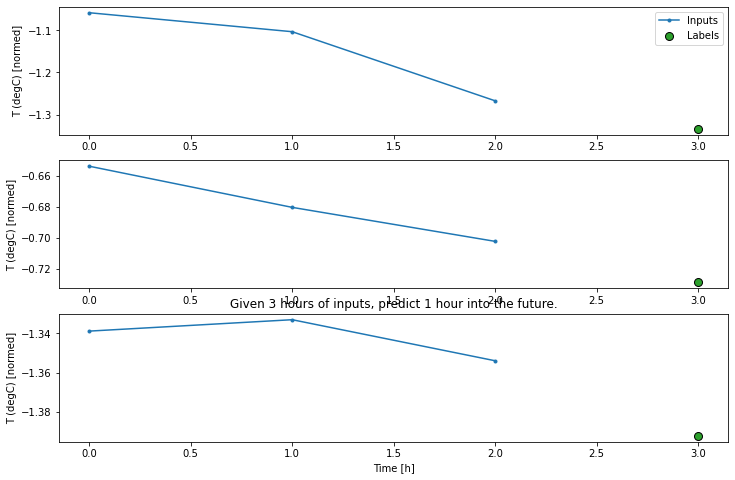

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 20s - loss: 0.0061 - mean_absolute_error: 0.0545

 33/438 [=>............................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0530 

 67/438 [===>..........................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0534

101/438 [=====>........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0534

136/438 [========>.....................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0541

169/438 [==========>...................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0535

203/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0537

235/438 [===============>..............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0536

269/438 [=================>............] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0534

302/438 [===================>..........] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0535

335/438 [=====================>........] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0533

367/438 [========================>.....] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0537

402/438 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0537

435/438 [============================>.] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0539

438/438 [==============================] - 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0539


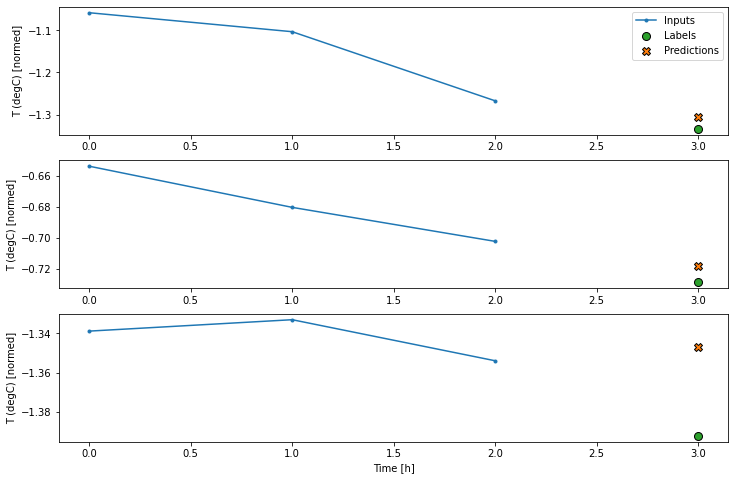

In [52]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 22s - loss: 0.0071 - mean_absolute_error: 0.0565

 23/438 [>.............................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569 

 48/438 [==>...........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0567

 70/438 [===>..........................] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0561

 95/438 [=====>........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0556

118/438 [=======>......................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0557

143/438 [========>.....................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0548

167/438 [==========>...................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0549

192/438 [============>.................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0548

216/438 [=============>................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

241/438 [===============>..............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0552

265/438 [=================>............] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0555

290/438 [==================>...........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0553

313/438 [====================>.........] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0550

337/438 [======================>.......] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0547

360/438 [=======================>......] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0548

384/438 [=========================>....] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0547

407/438 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0549

430/438 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0549

438/438 [==============================] - 1s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0550


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

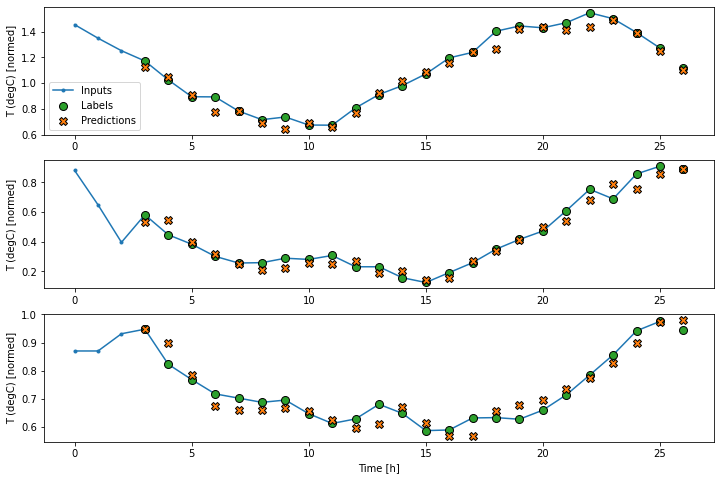

In [60]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](images/lstm_1_window.png)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 22s - loss: 0.0050 - mean_absolute_error: 0.0476

 22/438 [>.............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0515 

 43/438 [=>............................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0517

 65/438 [===>..........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

 87/438 [====>.........................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0518

108/438 [======>.......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

130/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0518

152/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

173/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

194/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

216/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

237/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

258/438 [================>.............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

280/438 [==================>...........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

302/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

324/438 [=====================>........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

346/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

368/438 [========================>.....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

390/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

411/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

434/438 [============================>.] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0514

438/438 [==============================] - 1s 2ms/step - loss: 0.0056 - mean_absolute_error: 0.0514


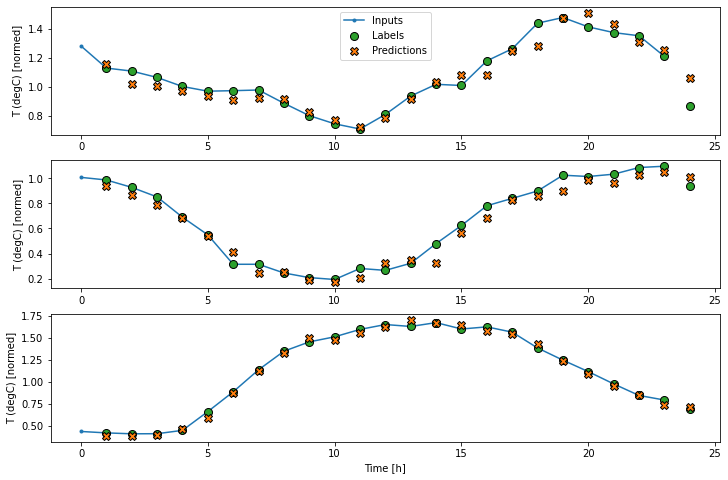

In [64]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

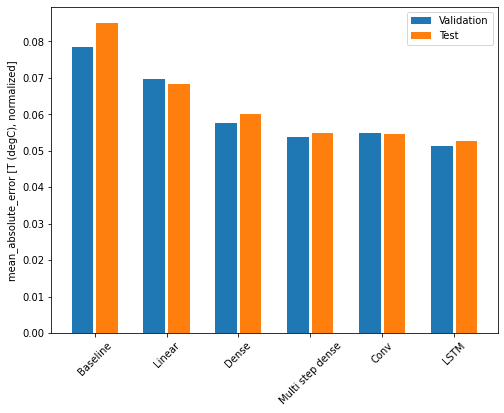

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0682
Dense       : 0.0600
Multi step dense: 0.0549
Conv        : 0.0548
LSTM        : 0.0527


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0851 - mean_absolute_error: 0.1613

 36/438 [=>............................] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.1604 

 73/438 [====>.........................] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

107/438 [======>.......................] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1591

142/438 [========>.....................] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1592

178/438 [===========>..................] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1594

212/438 [=============>................] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1592

246/438 [===============>..............] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1591

281/438 [==================>...........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

316/438 [====================>.........] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1591

349/438 [======================>.......] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1592

383/438 [=========================>....] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1591

416/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1590

438/438 [==============================] - 1s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 19s - loss: 0.0602 - mean_absolute_error: 0.1319

 23/439 [>.............................] - ETA: 0s - loss: 0.0756 - mean_absolute_error: 0.1346 

 46/439 [==>...........................] - ETA: 0s - loss: 0.0730 - mean_absolute_error: 0.1322

 68/439 [===>..........................] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.1303

 91/439 [=====>........................] - ETA: 0s - loss: 0.0703 - mean_absolute_error: 0.1309

114/439 [======>.......................] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.1310

137/439 [========>.....................] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1305

160/439 [=========>....................] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1299

184/439 [===========>..................] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1305

207/439 [=============>................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1302

229/439 [==============>...............] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1300

252/439 [================>.............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1303

275/439 [=================>............] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1305

298/439 [===================>..........] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1305

320/439 [====================>.........] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.1306

343/439 [======================>.......] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.1308

364/439 [=======================>......] - ETA: 0s - loss: 0.0699 - mean_absolute_error: 0.1308

386/439 [=========================>....] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1304

408/439 [==========================>...] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.1301

430/439 [============================>.] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1301

439/439 [==============================] - 1s 2ms/step - loss: 0.0690 - mean_absolute_error: 0.1302


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 22s - loss: 0.0668 - mean_absolute_error: 0.1241

 21/438 [>.............................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1209 

 42/438 [=>............................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1206

 63/438 [===>..........................] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1205

 84/438 [====>.........................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1209

105/438 [======>.......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1208

126/438 [=======>......................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1207

147/438 [=========>....................] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1206

168/438 [==========>...................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1209

190/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1210

210/438 [=============>................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1211

232/438 [==============>...............] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1210

253/438 [================>.............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1211

275/438 [=================>............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1212

295/438 [===================>..........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1212

316/438 [====================>.........] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1211

337/438 [======================>.......] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1211

358/438 [=======================>......] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1211

378/438 [========================>.....] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1210

399/438 [==========================>...] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1209

417/438 [===========================>..] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1210

438/438 [==============================] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1210

438/438 [==============================] - 1s 2ms/step - loss: 0.0617 - mean_absolute_error: 0.1210



CPU times: user 3min 47s, sys: 51.9 s, total: 4min 38s
Wall time: 1min 29s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 20s - loss: 0.0714 - mean_absolute_error: 0.1244

 22/438 [>.............................] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.1172 

 43/438 [=>............................] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1175

 65/438 [===>..........................] - ETA: 0s - loss: 0.0608 - mean_absolute_error: 0.1172

 87/438 [====>.........................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1176

109/438 [======>.......................] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1174

131/438 [=======>......................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1175

152/438 [=========>....................] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1175

173/438 [==========>...................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1175

194/438 [============>.................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1177

215/438 [=============>................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1178

236/438 [===============>..............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1177

258/438 [================>.............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1177

280/438 [==================>...........] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1177

301/438 [===================>..........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

323/438 [=====================>........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

344/438 [======================>.......] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

365/438 [========================>.....] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1180

386/438 [=========================>....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

407/438 [==========================>...] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1180

428/438 [============================>.] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

438/438 [==============================] - 1s 2ms/step - loss: 0.0619 - mean_absolute_error: 0.1180



CPU times: user 1min 49s, sys: 25.1 s, total: 2min 14s
Wall time: 43.4 s


#### Performance

Here is the overall performance for these multi-output models.

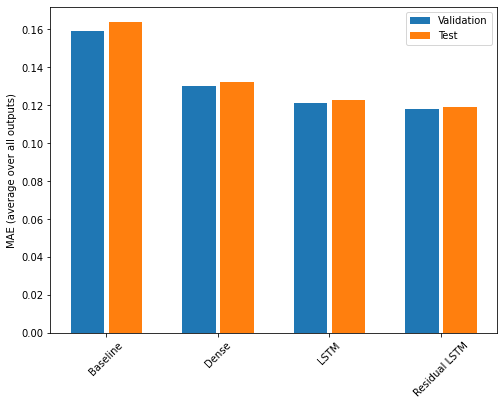

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1321
LSTM           : 0.1229
Residual LSTM  : 0.1191


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

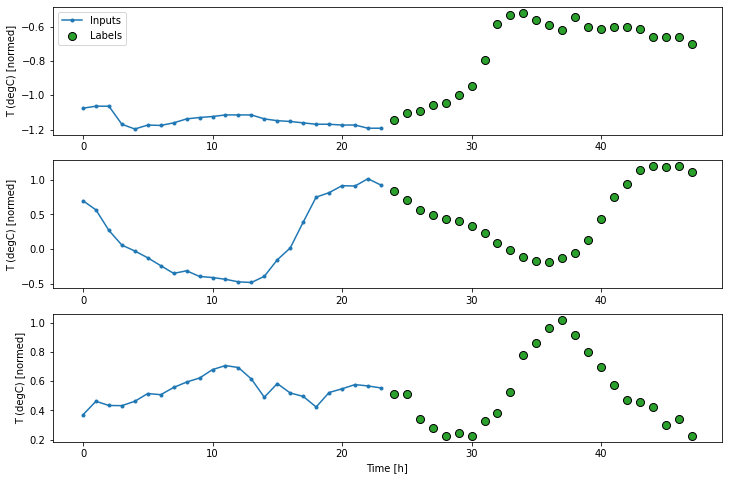

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 48s - loss: 0.5636 - mean_absolute_error: 0.4698

 36/437 [=>............................] - ETA: 0s - loss: 0.6208 - mean_absolute_error: 0.4952 

 72/437 [===>..........................] - ETA: 0s - loss: 0.6179 - mean_absolute_error: 0.4960

107/437 [======>.......................] - ETA: 0s - loss: 0.6223 - mean_absolute_error: 0.4984

142/437 [========>.....................] - ETA: 0s - loss: 0.6240 - mean_absolute_error: 0.4992

176/437 [===========>..................] - ETA: 0s - loss: 0.6259 - mean_absolute_error: 0.4999

211/437 [=============>................] - ETA: 0s - loss: 0.6258 - mean_absolute_error: 0.4995

245/437 [===============>..............] - ETA: 0s - loss: 0.6254 - mean_absolute_error: 0.4991

279/437 [==================>...........] - ETA: 0s - loss: 0.6277 - mean_absolute_error: 0.5000

313/437 [====================>.........] - ETA: 0s - loss: 0.6284 - mean_absolute_error: 0.5004

347/437 [======================>.......] - ETA: 0s - loss: 0.6276 - mean_absolute_error: 0.5001

381/437 [=========================>....] - ETA: 0s - loss: 0.6287 - mean_absolute_error: 0.5008

415/437 [===========================>..] - ETA: 0s - loss: 0.6283 - mean_absolute_error: 0.5007

437/437 [==============================] - 1s 1ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


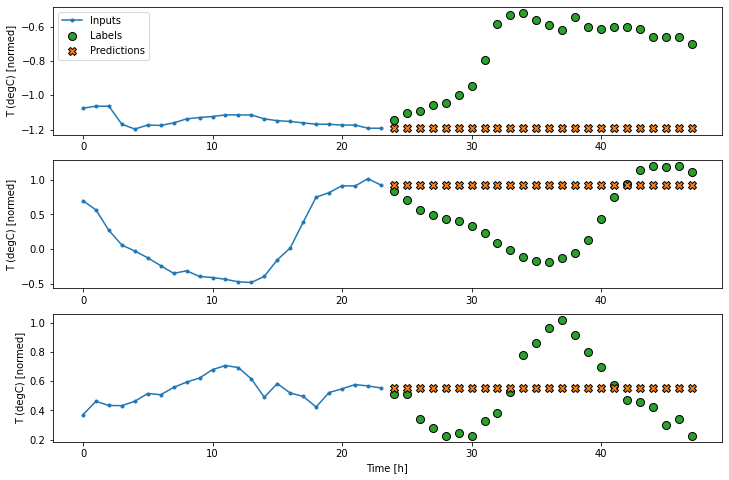

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 44s - loss: 0.4107 - mean_absolute_error: 0.3848

 34/437 [=>............................] - ETA: 0s - loss: 0.4212 - mean_absolute_error: 0.3937 

 68/437 [===>..........................] - ETA: 0s - loss: 0.4237 - mean_absolute_error: 0.3966

102/437 [======>.......................] - ETA: 0s - loss: 0.4258 - mean_absolute_error: 0.3961

136/437 [========>.....................] - ETA: 0s - loss: 0.4221 - mean_absolute_error: 0.3941

170/437 [==========>...................] - ETA: 0s - loss: 0.4222 - mean_absolute_error: 0.3937

204/437 [=============>................] - ETA: 0s - loss: 0.4228 - mean_absolute_error: 0.3939

238/437 [===============>..............] - ETA: 0s - loss: 0.4232 - mean_absolute_error: 0.3941

271/437 [=================>............] - ETA: 0s - loss: 0.4240 - mean_absolute_error: 0.3946

305/437 [===================>..........] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.3941

339/437 [======================>.......] - ETA: 0s - loss: 0.4245 - mean_absolute_error: 0.3946

373/437 [========================>.....] - ETA: 0s - loss: 0.4259 - mean_absolute_error: 0.3955

406/437 [==========================>...] - ETA: 0s - loss: 0.4257 - mean_absolute_error: 0.3953

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


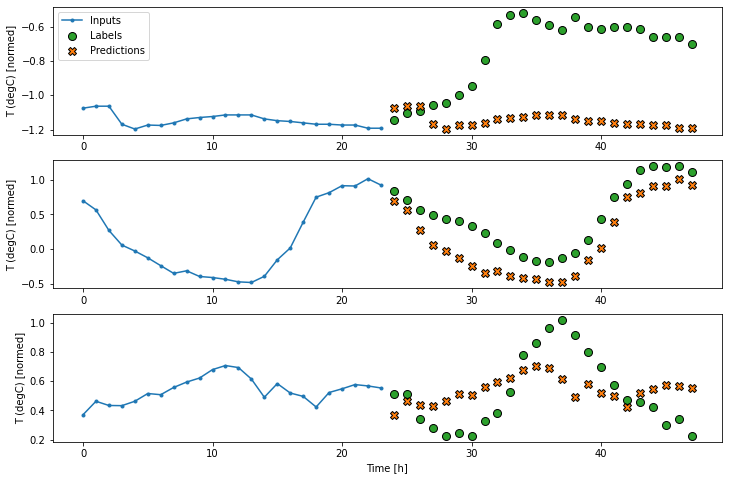

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 20s - loss: 0.2850 - mean_absolute_error: 0.3250

 29/437 [>.............................] - ETA: 0s - loss: 0.2634 - mean_absolute_error: 0.3104 

 57/437 [==>...........................] - ETA: 0s - loss: 0.2658 - mean_absolute_error: 0.3114

 83/437 [====>.........................] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3061

111/437 [======>.......................] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3059

138/437 [========>.....................] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3061

164/437 [==========>...................] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3060

191/437 [============>.................] - ETA: 0s - loss: 0.2570 - mean_absolute_error: 0.3060

218/437 [=============>................] - ETA: 0s - loss: 0.2571 - mean_absolute_error: 0.3060

247/437 [===============>..............] - ETA: 0s - loss: 0.2571 - mean_absolute_error: 0.3063

276/437 [=================>............] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3059

303/437 [===================>..........] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3058

331/437 [=====================>........] - ETA: 0s - loss: 0.2567 - mean_absolute_error: 0.3059

358/437 [=======================>......] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3056

387/437 [=========================>....] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3057

415/437 [===========================>..] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3053

437/437 [==============================] - 1s 2ms/step - loss: 0.2555 - mean_absolute_error: 0.3052


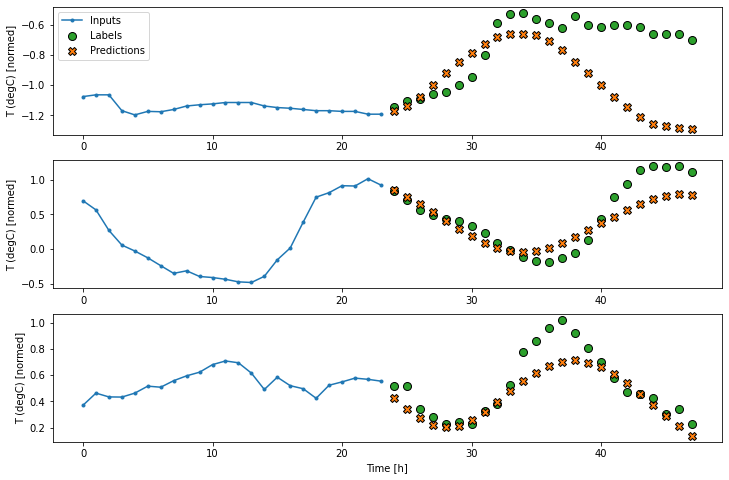

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

  1/437 [..............................] - ETA: 19s - loss: 0.2120 - mean_absolute_error: 0.2780

 26/437 [>.............................] - ETA: 0s - loss: 0.2175 - mean_absolute_error: 0.2826 

 51/437 [==>...........................] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2834

 76/437 [====>.........................] - ETA: 0s - loss: 0.2179 - mean_absolute_error: 0.2831

102/437 [======>.......................] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2840

127/437 [=======>......................] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2843

152/437 [=========>....................] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2843

176/437 [===========>..................] - ETA: 0s - loss: 0.2215 - mean_absolute_error: 0.2848

202/437 [============>.................] - ETA: 0s - loss: 0.2215 - mean_absolute_error: 0.2848

225/437 [==============>...............] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2846

250/437 [================>.............] - ETA: 0s - loss: 0.2207 - mean_absolute_error: 0.2841

275/437 [=================>............] - ETA: 0s - loss: 0.2209 - mean_absolute_error: 0.2844

300/437 [===================>..........] - ETA: 0s - loss: 0.2209 - mean_absolute_error: 0.2844

325/437 [=====================>........] - ETA: 0s - loss: 0.2213 - mean_absolute_error: 0.2847

351/437 [=======================>......] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2848

376/437 [========================>.....] - ETA: 0s - loss: 0.2214 - mean_absolute_error: 0.2849

402/437 [==========================>...] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2851

427/437 [============================>.] - ETA: 0s - loss: 0.2216 - mean_absolute_error: 0.2851

437/437 [==============================] - 1s 2ms/step - loss: 0.2214 - mean_absolute_error: 0.2850


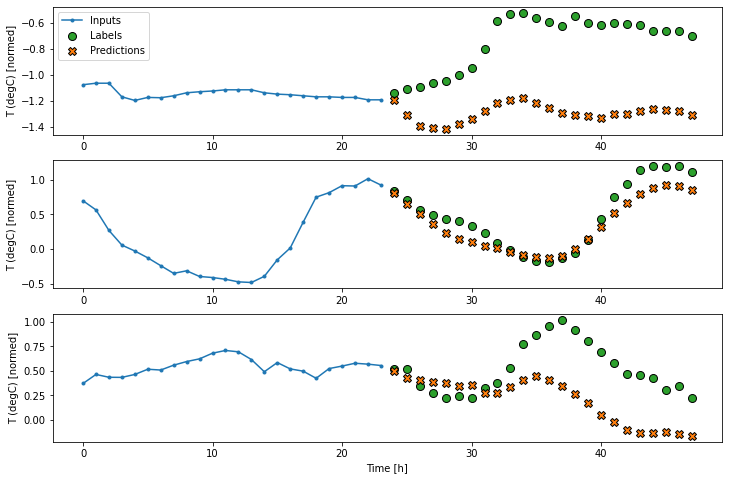

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 21s - loss: 0.2638 - mean_absolute_error: 0.3060

 24/437 [>.............................] - ETA: 0s - loss: 0.2209 - mean_absolute_error: 0.2833 

 49/437 [==>...........................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2802

 73/437 [====>.........................] - ETA: 0s - loss: 0.2167 - mean_absolute_error: 0.2805

 97/437 [=====>........................] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2791

120/437 [=======>......................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2789

145/437 [========>.....................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2796

170/437 [==========>...................] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2795

196/437 [============>.................] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2795

222/437 [==============>...............] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2796

247/437 [===============>..............] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2793

272/437 [=================>............] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2790

297/437 [===================>..........] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2787

322/437 [=====================>........] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2791

347/437 [======================>.......] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2791

373/437 [========================>.....] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2789

400/437 [==========================>...] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2789

426/437 [============================>.] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2790

437/437 [==============================] - 1s 2ms/step - loss: 0.2136 - mean_absolute_error: 0.2788


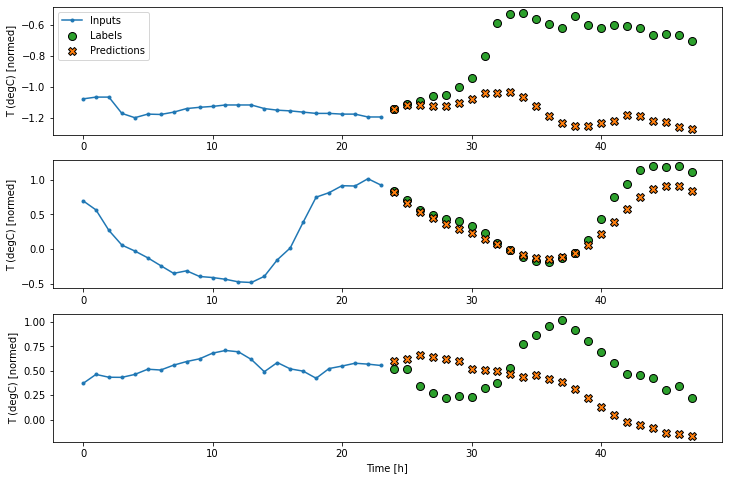

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 19s - loss: 0.2350 - mean_absolute_error: 0.2975

 25/437 [>.............................] - ETA: 0s - loss: 0.2182 - mean_absolute_error: 0.2887 

 50/437 [==>...........................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2878

 74/437 [====>.........................] - ETA: 0s - loss: 0.2169 - mean_absolute_error: 0.2875

 98/437 [=====>........................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2873

122/437 [=======>......................] - ETA: 0s - loss: 0.2167 - mean_absolute_error: 0.2880

146/437 [=========>....................] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2881

171/437 [==========>...................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2880

192/437 [============>.................] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2872

216/437 [=============>................] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2867

240/437 [===============>..............] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2865

265/437 [=================>............] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2865

289/437 [==================>...........] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2868

312/437 [====================>.........] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2865

335/437 [=====================>........] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2866

359/437 [=======================>......] - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.2869

384/437 [=========================>....] - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.2870

409/437 [===========================>..] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2867

435/437 [============================>.] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2866

437/437 [==============================] - 1s 2ms/step - loss: 0.2147 - mean_absolute_error: 0.2866


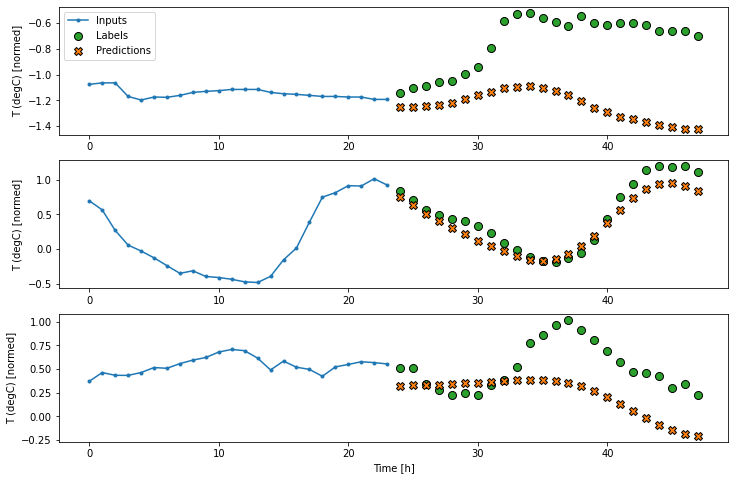

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

  1/437 [..............................] - ETA: 24s - loss: 0.2233 - mean_absolute_error: 0.3051

  9/437 [..............................] - ETA: 3s - loss: 0.2262 - mean_absolute_error: 0.3038 

 17/437 [>.............................] - ETA: 2s - loss: 0.2261 - mean_absolute_error: 0.3033

 25/437 [>.............................] - ETA: 2s - loss: 0.2232 - mean_absolute_error: 0.3021

 32/437 [=>............................] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.3010

 40/437 [=>............................] - ETA: 2s - loss: 0.2212 - mean_absolute_error: 0.2999

 48/437 [==>...........................] - ETA: 2s - loss: 0.2246 - mean_absolute_error: 0.3017

 56/437 [==>...........................] - ETA: 2s - loss: 0.2244 - mean_absolute_error: 0.3015

 64/437 [===>..........................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.3017

 72/437 [===>..........................] - ETA: 2s - loss: 0.2247 - mean_absolute_error: 0.3010

 79/437 [====>.........................] - ETA: 2s - loss: 0.2255 - mean_absolute_error: 0.3013

 86/437 [====>.........................] - ETA: 2s - loss: 0.2248 - mean_absolute_error: 0.3012

 94/437 [=====>........................] - ETA: 2s - loss: 0.2249 - mean_absolute_error: 0.3012

102/437 [======>.......................] - ETA: 2s - loss: 0.2245 - mean_absolute_error: 0.3011

109/437 [======>.......................] - ETA: 2s - loss: 0.2254 - mean_absolute_error: 0.3017

117/437 [=======>......................] - ETA: 2s - loss: 0.2253 - mean_absolute_error: 0.3015

125/437 [=======>......................] - ETA: 2s - loss: 0.2252 - mean_absolute_error: 0.3016

132/437 [========>.....................] - ETA: 2s - loss: 0.2247 - mean_absolute_error: 0.3013

140/437 [========>.....................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.3013

147/437 [=========>....................] - ETA: 2s - loss: 0.2252 - mean_absolute_error: 0.3013

154/437 [=========>....................] - ETA: 2s - loss: 0.2254 - mean_absolute_error: 0.3015

162/437 [==========>...................] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.3015

169/437 [==========>...................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.3016

177/437 [===========>..................] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.3016

184/437 [===========>..................] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.3016

191/437 [============>.................] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3013

198/437 [============>.................] - ETA: 1s - loss: 0.2248 - mean_absolute_error: 0.3012

206/437 [=============>................] - ETA: 1s - loss: 0.2245 - mean_absolute_error: 0.3010

214/437 [=============>................] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3013

221/437 [==============>...............] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.3016

228/437 [==============>...............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.3018

235/437 [===============>..............] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.3014

242/437 [===============>..............] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.3013

249/437 [================>.............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3016

257/437 [================>.............] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.3016

265/437 [=================>............] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3017

273/437 [=================>............] - ETA: 1s - loss: 0.2259 - mean_absolute_error: 0.3017

281/437 [==================>...........] - ETA: 1s - loss: 0.2264 - mean_absolute_error: 0.3021

289/437 [==================>...........] - ETA: 1s - loss: 0.2272 - mean_absolute_error: 0.3025

296/437 [===================>..........] - ETA: 1s - loss: 0.2273 - mean_absolute_error: 0.3026

304/437 [===================>..........] - ETA: 0s - loss: 0.2271 - mean_absolute_error: 0.3025

312/437 [====================>.........] - ETA: 0s - loss: 0.2272 - mean_absolute_error: 0.3027

320/437 [====================>.........] - ETA: 0s - loss: 0.2271 - mean_absolute_error: 0.3026

328/437 [=====================>........] - ETA: 0s - loss: 0.2274 - mean_absolute_error: 0.3026

336/437 [======================>.......] - ETA: 0s - loss: 0.2274 - mean_absolute_error: 0.3026

344/437 [======================>.......] - ETA: 0s - loss: 0.2273 - mean_absolute_error: 0.3026

352/437 [=======================>......] - ETA: 0s - loss: 0.2270 - mean_absolute_error: 0.3024

359/437 [=======================>......] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3021

366/437 [========================>.....] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3021

373/437 [========================>.....] - ETA: 0s - loss: 0.2266 - mean_absolute_error: 0.3021

381/437 [=========================>....] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3022

388/437 [=========================>....] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3022

396/437 [==========================>...] - ETA: 0s - loss: 0.2265 - mean_absolute_error: 0.3021

404/437 [==========================>...] - ETA: 0s - loss: 0.2262 - mean_absolute_error: 0.3018

412/437 [===========================>..] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3021

419/437 [===========================>..] - ETA: 0s - loss: 0.2268 - mean_absolute_error: 0.3022

427/437 [============================>.] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3021

435/437 [============================>.] - ETA: 0s - loss: 0.2267 - mean_absolute_error: 0.3020

437/437 [==============================] - 3s 7ms/step - loss: 0.2267 - mean_absolute_error: 0.3020


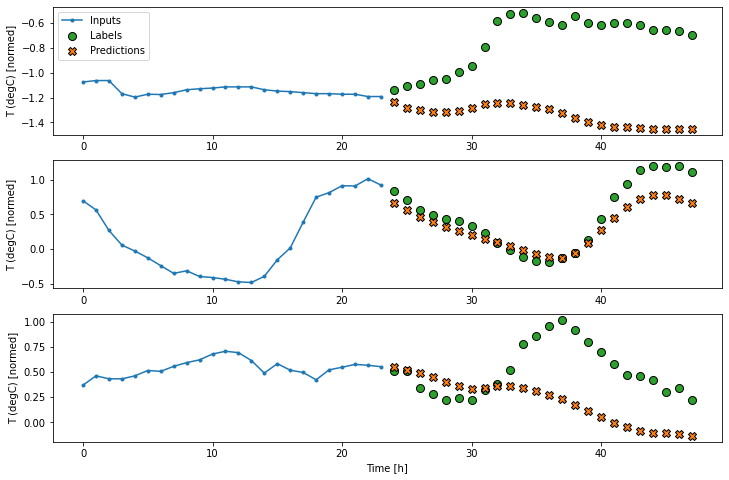

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

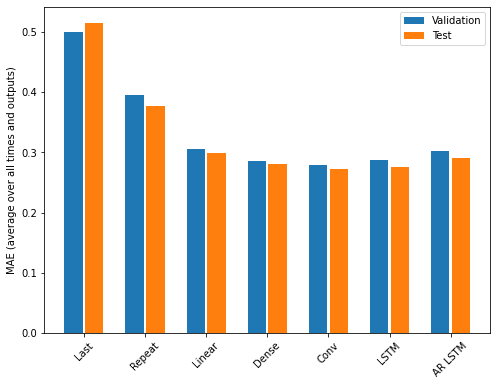

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2984
Dense   : 0.2800
Conv    : 0.2727
LSTM    : 0.2755
AR LSTM : 0.2903


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
